In [34]:
#Importing all the necessary libraries required for our Decision Tree AI
import numpy as np
import pandas as pd
from sklearn.tree import export_text
from sklearn.tree import export_graphviz
from six import StringIO 
import csv
from IPython.display import Image
import pydotplus
from termcolor import colored
from sklearn.model_selection import train_test_split
import json
from sklearn.tree import DecisionTreeClassifier
from nbconvert import PythonExporter
from sklearn import metrics
import firebase_admin
from firebase_admin import credentials,storage
from firebase_admin import firestore


In [35]:
#Initializing the firestore client to connect to our website database
if not firebase_admin._apps:
   cred = credentials.Certificate("we-don-t-byte---ass-firebase-adminsdk-kdbj6-ec500ebd6d.json")
   firebase_admin.initialize_app(cred, {"storageBucket": "we-don-t-byte---ass.appspot.com"})
   db = firestore.client()

In [36]:
#Before loading dataset we declare our column names to easily identify each file in our data.
col_names = ['Prod_ID', 'Prod_Cat', 'User_ID', 'User_Province', 'Event', 'Clicks', 'Wishlist', 'Recommend']

#loading our Dataset(To be slpit into Training and Validation Data)
#Note: Test data will be fetched straight from the database, get compared to the training and validation we have to avoid testing 
#----- the model using the data it has seen already.

pima = pd.read_csv("../assets/DecisionTreeData/Train_Data.csv", header=None, names=col_names)

#Setting our decision features(attributes to be used in our decision making---Decision Tree)
feature_cols = ['Prod_Cat', 'User_Province', 'Clicks', 'Wishlist']

#Setting our X and y variables for our Model -- Using our "Recommend" Column as our label - Since this is a decision tree(Supervised Learning)
#and our feature Columns as our x "terms"
X = pima[feature_cols]
y = pima.Recommend

#Here we split our dataset into training set and validation set(regarded as test in the following line)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% validation

#Note: Validation set will be used to Validate(test) our model and eventually calculate our Model accuracy before and after Pruning
# --- but not to recommend...  

#Here we declare our DecisionTreeClassifier as CLF and eventually train it using our train set and the criterion being "entropy"....
clf = DecisionTreeClassifier(criterion="entropy")
clf = clf.fit(X_train,y_train)

#We Create two json objects provinceJson and categoryJson to map our provinces and categories, respectively, to numerical values 
#that the model can be able to train and make neccessary calculations with
provinceJson =  '{ "Limpopo" : 1,"Gauteng" : 2,"Free State" : 3,"Western Cape" : 4,"KwaZulu-Natal" : 5,"North West" : 6,"Northern Cape" : 7,"Eastern Cape" : 8,"Mpumalanga" : 9}'

categoryJson =  '{"Books" : 1, "Shoes" : 2, "Clothing" : 3, "Tech" : 4, "Kitchen" : 5}'

loadProvinceJ = json.loads(provinceJson)
   
loadCategoryJ = json.loads(categoryJson)

#Here we keep track of all trained entries for later purposes...(Avoid testing the exact entries we've trained)
# thus avoiding returning large lists as well......
with open('../assets/DecisionTreeData/Train_Data.csv','r') as file1:
    trainedEntries = [line for line in csv.reader(file1, delimiter=',')]


In [37]:
#Here we are collecting all our products from the database (all documents in firebase)
print('collecting Products... ')
products_ref = db.collection('Products')
Products_docs = products_ref.get()

print('collecting User collection... ')
#Collecting the user's collection from firebase
users_ref = db.collection('Users')
users_docs = users_ref.list_documents()
print('All set!!!')

collecting Products... 
collecting User collection... 
All set!!!


In [38]:
pima

,Prod_ID,Prod_Cat,User_ID,User_Province,Event,Clicks,Wishlist,Recommend
0,YMJqe9iK1fZCJJQn3WHV,2,EjT2OL7otRShSYDc2FBPooYekZC3,1,wishlist,2,1,1
1,YMJqe9iK1fZCJJQn3WHV,2,EjT2OL7otRShSYDc2FBPooYekZC3,1,view,2,0,1
2,YMJqe9iK1fZCJJQn3WHV,2,EjT2OL7otRShSYDc2FBPooYekZC3,1,view,2,0,0
3,YG000zPM4o8b4JDsFpjx,4,hFCh5cEjAISQRtq8ZyXxiJhVuV03,8,view,1,0,0
4,YG000zPM4o8b4JDsFpjx,4,hFCh5cEjAISQRtq8ZyXxiJhVuV03,8,cart,1,0,0
...,...,...,...,...,...,...,...,...
555,03CUmWipKQZ73hF5be5b,3,HeSu08geVubHffYrUuuw2dbpmqx2,1,wishlist,6,1,1
556,03CUmWipKQZ73hF5be5b,3,HeSu08geVubHffYrUuuw2dbpmqx2,1,view,6,0,0
557,03CUmWipKQZ73hF5be5b,3,Cb0TFCwYZUUj5xJA43vG9W9LUbn1,3,wishlist,6,1,1
558,03CUmWipKQZ73hF5be5b,3,kQ0okpadrAURKYiYvXdqoiV7I2c2,6,view,6,0,1


In [39]:
#Declare a list of recommendations (This is one of the final products of this Algorithm)
recommended_products = []
all_products = []

uid = '1RvEwuC2eCdzoKyaATXC9pNsXwH3'
    
province = ''
    
#Get User information--- 
userDoc1 = users_ref.document(uid)
userColl1 = userDoc1.collection('info')
userColl2 = userDoc1.collection('Wishlist')
colDocs1 = userColl1.get()
colDocs2 = userColl2.list_documents()#Items in wishlist
info = userColl1.get()
    
#    Province
#
#Load the json value
for colD_doc in colDocs1:
    province = colD_doc.get('province')
    province = loadProvinceJ[province]

    
#Note that here we're only recommending to users with a defined location, if province is null, then no recommendations
# the continue statement goes to the next user (iteration)... else : we iterate through every product in the database running 
# it through our decision tree algorithm and getting a prediction of that and that's what we'll use for recommendations.. 
if province == '':
    print("No recommendations for this user")
else:      
        #For each product in the database :   
    for prod_doc in Products_docs:  
        pid = prod_doc.id  #product Id

        s = pid in colDocs2   #Returning true if the item is in the wishlist.....
                ###
                # Wishlist
                ####
        print(s)
        if s :            
            wishlist = 1
            
        else:
            wishlist = 0   
                
        noOfClicks = 1    #To avoid null errors and a lot other unnecessary errors we give each product at least one click....
            #
            #   Clicks
            #
        if prod_doc.get('clicks')>= 1:
            noOfClicks = prod_doc.get('clicks')
            
        category = prod_doc.get('category')
        # print("Category: " + str(loadCategoryJ[category]))
        # print("Clicks: " + str(noOfClicks))
        category = loadCategoryJ[category]
        
        listTemp = [pid, category, uid, province, 'view', noOfClicks, wishlist] #Create test entry for this product to be run through the decision tree classifier....

        if listTemp in trainedEntries : #Later purposes is now,lol, if this exact entery has been seen before in training, then don't test it
            continue
        else:
                #creating a dataframe from our entry to be able to run through the classifier...
            test_data = pd.DataFrame([listTemp], columns=['Prod_ID', 'Prod_Cat', 'User_ID', 'User_Province', 'Event', 'Clicks', 'Wishlist']) 

            y_predict = clf.predict(test_data[feature_cols]) #Get our 1(recommend) or 0(Do not recommend)

            if(y_predict == 1):
                str = pid    #Using a pipe delimeter
                recommended_products.append(str) #appending to recommendation list
                all_products.append(str)
                str = colored(pid, 'green')
                print(str)
                print(y_predict)
            else:
                all_products.append(pid)
                str = colored(pid, 'red')
                print(str)
                print(y_predict)

    #Shows the total number of products to be recommended to the user compared to the original number of products...              
    print(len(all_products))
    print(len(recommended_products))

False
01jWTF8NnJRanatcqWWA
[0]
False
03qJv4WzHoKBslyT6bcw
[1]
False
0FrZIkNP98yWbVRuE1Wd
[1]
False
0cCtsXbwGQqu7LoLIFmv
[1]
False
0cHxbCxG7mY7xA7l1Dpn
[1]
False
0s4fAbVOqdJv7eYcZ5Zr
[1]
False
0tOD2R8VprURTzYF4b9m
[1]
False
0zwT3y7XarK0kA2m6459
[0]
False
1GOto1UFk2QuXBdSSyUj
[0]
False
1Q30dEBi2W6i358rT2g4
[1]
False
1WCHDQT6LwpTDo6sX1wv
[0]
False
1YZ02BpCyAzkuMs0uTTU
[0]
False
1iSLejnhJVgmRe0iwHkw
[0]
False
1lZkdgEeh9MLTJfUYnby
[1]
False
20EI9jhYnDyhjYX79yCH
[1]
False
2ZIjNxeaNXgZS3KHhMUP
[1]
False
2ffKEUPN9bWtWmYMfo8C
[0]
False
2gs3DUIYZuaXqgZtU0bs
[0]
False
2sGL2xUGipXFhuTiv6yW
[1]
False
2sZA2SnVdR8wgU5Es6CK
[0]
False
2suTIt6CxtXy6j7dnAaH
[1]
False
32JR4GcAFMlyqvzR3LoP
[1]
False
3HDnaI0Tifr70zhnaPK8
[1]
False
3Kcolr6Llq9geCIQ6RQ7
[1]
False
3T805En1xjLM7v1otfWW
[1]
False
3Y0LgxYEZGlkNbfTuxdl
[0]
False
3cOmZEqJC7qH2IVGxRiw
[0]
False
3cSCaJVIW6nwFfaqOTBx
[0]
False
3dCGNLFbfnOQ0OywT4kx
[0]
False
3gDDKe1ZQgQF8KZnjQhy
[0]
False
3nByTl035FS7GLeGRNrs
[1]
False
3q2W3b0EKePJifmPEgDc
[1]
False
4D

In [40]:
#export our final list of recommendation as csv file to our assets folder in our project....
np.savetxt("../assets/DecisionTreeOutputs/final_recommendations.csv", recommended_products, delimiter=",", fmt='%s')
np.savetxt("../assets/DecisionTreeOutputs/final_recommendations.txt", recommended_products, delimiter=",", fmt='%s')

In [41]:
#Performance testing using our validation data..... X_test was initialised as a validation set...

#Before Pruning!!!!!!!!!!!!!!!!!!!!!!!!
y_predict = clf.predict(X_test)

#Get the accuracy of the model clf...

AccuracyBeforePruning = metrics.accuracy_score(y_test, y_predict)
print("-----------------------------------------------ACCURACY BEFORE PRUNING---------------------------------\n")
print(colored(AccuracyBeforePruning, 'green'))
print("\n-------------------------------------------------------------------------------------------------------\n")


#Building the decision tree, the visual decision tree diagram and exporting the diagram as .png and 
# saved under the assests folder in our project... 
r = export_text(clf, feature_names=feature_cols)

print(colored(r, 'blue'))

dot_data = StringIO()

export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('../assets/DecisionTreeOutputs/recommendations.png')
Image(graph.create_png())

-----------------------------------------------ACCURACY BEFORE PRUNING---------------------------------

0.6488095238095238

-------------------------------------------------------------------------------------------------------

|--- Wishlist <= 0.50
|   |--- Clicks <= 6.50
|   |   |--- Prod_Cat <= 1.50
|   |   |   |--- Clicks <= 1.50
|   |   |   |   |--- class: 1
|   |   |   |--- Clicks >  1.50
|   |   |   |   |--- User_Province <= 7.00
|   |   |   |   |   |--- User_Province <= 3.50
|   |   |   |   |   |   |--- User_Province <= 2.50
|   |   |   |   |   |   |   |--- Clicks <= 2.50
|   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |--- Clicks >  2.50
|   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- User_Province >  2.50
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- User_Province >  3.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |--- User_Province >  7.00
|   |   |   |   |   |--- class: 0
|   |   |--- Pro

InvocationException: GraphViz's executables not found

-----------------------------------------------ACCURACY AFTER PRUNING-------------------------------

0.6666666666666666

-------------------------------------------------------------------------------------------------------

|--- Wishlist <= 0.50
|   |--- Clicks <= 6.50
|   |   |--- Prod_Cat <= 1.50
|   |   |   |--- Clicks <= 1.50
|   |   |   |   |--- class: 1
|   |   |   |--- Clicks >  1.50
|   |   |   |   |--- User_Province <= 7.00
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- User_Province >  7.00
|   |   |   |   |   |--- class: 0
|   |   |--- Prod_Cat >  1.50
|   |   |   |--- Clicks <= 4.50
|   |   |   |   |--- Prod_Cat <= 3.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- Prod_Cat >  3.50
|   |   |   |   |   |--- class: 1
|   |   |   |--- Clicks >  4.50
|   |   |   |   |--- Prod_Cat <= 3.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- Prod_Cat >  3.50
|   |   |   |   |   |--- class: 0
|   |--- Clicks >  6.50
|   |   |--- Clicks <= 28.00
|   |   |   |-

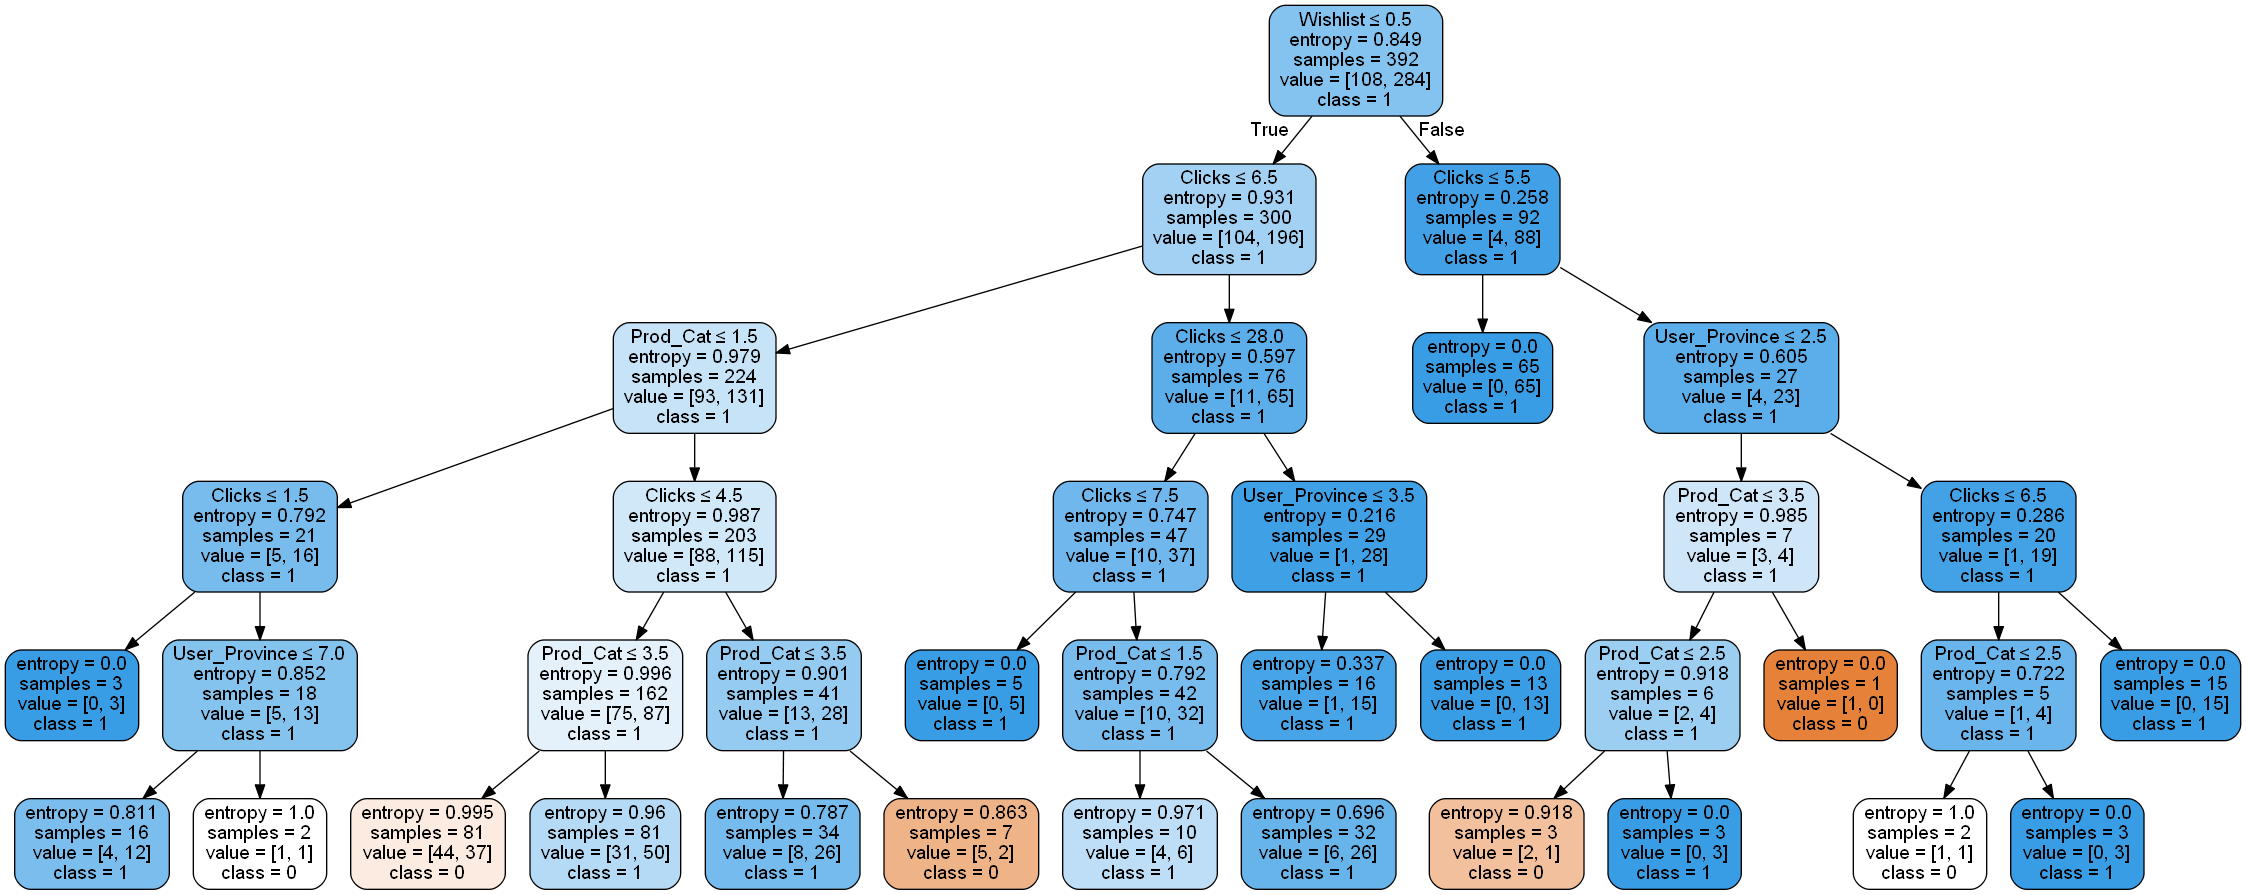

In [9]:
#After Pruning!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#We prune the tree to reduce the complexity, makes it easier to interpret 
# by cutting off the redundency of some nodes of the tree... 
# 
#Sometimes there's a tradeoff between removing redundency and a slight decrease in model accuracy... A fair tradeoff....
# what's good about our model is that most of the time the accuracy before and after pruning is likely the same, or even better after pruning

clf = DecisionTreeClassifier(criterion="entropy", max_depth=5) #Given a depth of 5 to make the tree less complicated(Avoid overfitting)

clf = clf.fit(X_train,y_train) #Train it again...

y_pred = clf.predict(X_test)

AccuracyAfterPruning = metrics.accuracy_score(y_test, y_pred)

print("-----------------------------------------------ACCURACY AFTER PRUNING-------------------------------\n")
print(colored(AccuracyAfterPruning, 'green'))
print("\n-------------------------------------------------------------------------------------------------------\n")

r = export_text(clf, feature_names=feature_cols)

if(AccuracyBeforePruning <= AccuracyAfterPruning):
    print(colored(r, 'green'))
else:
    print(colored(r, 'red'))

dot_data = StringIO()

export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('../assets/DecisionTreeOutputs/recommendations(Pruned).png')
Image(graph.create_png())


In [11]:
#Exporting and saving our accuracy file in a form Accuracy Before Pruning, Accuracy After Pruning
accuracy = []
accuracy.append(AccuracyBeforePruning)
accuracy.append(AccuracyAfterPruning)
np.savetxt("../assets/DecisionTreeOutputs/accuracies.csv", accuracy, delimiter=",", fmt='%s')

#Exporting our final files to firebase (Note these are global files, files that do not depend on the user -- hence we didn't push the final _recommendations.csv file)
#First we append them into an array...
ai_results = []

ai_results.append('DecisionTreeOutputs/recommendations.png')
ai_results.append('DecisionTreeOutputs/recommendations(Pruned).png')
ai_results.append('DecisionTreeOutputs/accuracies.csv')

for x in ai_results:

    bucket = storage.bucket()
    blob = bucket.blob(x)
    outfile='../assets/' + x
    with open(outfile, 'rb') as my_file:
        blob.upload_from_file(my_file)



NameError: name 'AccuracyBeforePruning' is not defined